# Scrape Dashboard Data for COVID Cases 
## in Pinellas County Schools

In this notebook, we develop tools to scrape and analyze the data contained in Pinellas County School's COVID database. The tools include county wide totals, school by school analyses, and data visualization.

## Setting the constants and loading some packages
Below, two url's are loaded as strings. The first url, `URL`, is the PCSB web page containing COVID case numbers for each school each day they are reported. This web page provides some searchability of the COVID results during the 2021-2022 school year in Pinellas County Schools. We do not need the searchability functionality of the webpage; we need the data contained in the database so that we can analyze and visualize it with pandas and matplotlib. To get the whole database, only only needs to click on the `Submit` button without any filters applied. Then the web page dynamically displays a table splayed over several pages. 


In [5]:
#Load packages
import pandas as pd
import matplotlib.pyplot as plt
import PCS_COVID_ScraPy as PCS
from datetime import date
import matplotlib.dates as mdates



#Set URL
URL = 'https://www.pcsb.org/covid19cases'
URL_2020_2021 = 'https://www.pcsb.org/Page/34025'

#Set driver path !!!Important - every user will have a different driver path! See readme.md for more info!
driver_path = "C:/webdrivers/chromedriver.exe"



## Scraping the table into a df

Once the variables are set above, we can run the wrapper function. This function is likely to throw errors such as "StaleElement" or "Driver not Found" until you:
  1. Get the timer set appropriately for your internet connection and page load times, and 
  2. Get consistent behavior from the web browser you are driving. 

In the case of those types of errors, close the browser that opens when this operates and re-run this cell. You may get several consecutive errors, but it will eventually work. You can also try to re-run the first cell and increase the delay time.

This routine will give status updates of how many pages it is scraping and how many it has scraped.

In [6]:
data_dict, data_df = PCS.Scrape_data(URL, driver_path, 2)

Iteration  0 . Clicking "..." to obtain pages after  10 ;
 searching for the last page.
Iteration  1 . Clicking "..." to obtain pages after  10 ;
 searching for the last page.


StaleElementReferenceException: Message: stale element reference: element is not attached to the page document
  (Session info: chrome=92.0.4515.159)


## Data Analysis

From this point on, we employ pandas and matplotlib to analyze and visualize the data. This notebook allows you to slice the data into various bins, by date, by school, by category, and shows some clever ways to plot the data compared to last year's data. 

In [33]:
#Verify the size the dataframe. There are approximately 25 rows per page scraped (in most cases). 

#Uncomment the line below if the data have extra columns 0, 1, and 2 in the dataframe. This happens
#sometimes when the scraping happens too fast for th table to load.
#data_df.drop(columns=[0, 1, 2], inplace=True)

data_df['Date'] = pd.to_datetime(data_df['Date'], yearfirst=True)
print(data_df.columns)
print(data_df.dtypes)
print(data_df.shape)




Index(['Date', 'Locations affected', 'Number of positive employees',
       'Number of positive students', 'Total cases',
       'Cumulative Sum Students'],
      dtype='object')
Date                            datetime64[ns]
Locations affected                      object
Number of positive employees           float64
Number of positive students            float64
Total cases                            float64
Cumulative Sum Students                float64
dtype: object
(265, 6)


In [8]:
#Save the datadump. If you want to save a .csv file, un-comment the last line and run this cell.

today = date.today()
filename = 'data_dump_' + today.strftime("%Y%m%d") +'.csv'
print(filename)
#Uncomment the line below to save the data 
pd.DataFrame.to_csv(data_df, filename)

data_dump_20210818.csv


(265, 6)
Total cases in district = 469.0
Total covid+ student cases in district = 327.0(0.327% of students)
Total covid+ employees cases in district = 142.0
            Number of positive employees  Number of positive students  \
Date                                                                    
2021-08-11                          37.0                         72.0   
2021-08-12                          19.0                         76.0   
2021-08-13                          22.0                         48.0   
2021-08-16                          31.0                         56.0   
2021-08-17                          33.0                         75.0   

            Total cases  Cumulative Sum Students  
Date                                              
2021-08-11        109.0                     72.0  
2021-08-12         95.0                    119.0  
2021-08-13         70.0                    101.0  
2021-08-16         87.0                    130.0  
2021-08-17        108.0  

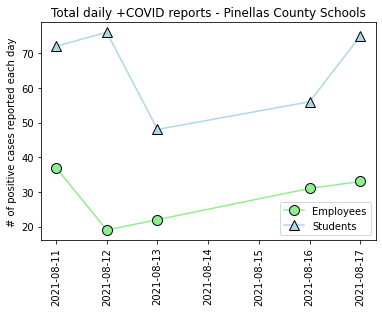

In [43]:
pcsb_students_2019 = 100000
hcsb_students_2019 = 223305

#Mask for cases since the beginning of the school year, 8/11/2021
school_year_mask = data_df['Date']>='2021/08/11'
data_df = data_df.loc[school_year_mask]

#Add column for total cases, calculate grand total.
data_df['Total cases'] = data_df['Number of positive employees'] + data_df['Number of positive students']
print(data_df.shape)
print('Total cases in district = ' + str(sum(data_df['Total cases'].dropna())))
total_cases_students = sum(data_df['Number of positive students'].dropna())
print('Total covid+ student cases in district = ' + str(total_cases_students) + '(' + str(total_cases_students/pcsb_students_2019*100) + "%" + ' of students)')
total_cases_employees = sum(data_df['Number of positive employees'].dropna())
print('Total covid+ employees cases in district = ' + str(total_cases_employees))
cases_by_date = data_df.groupby('Date').sum().sort_values(by='Date', ascending=True)
print(cases_by_date)
fig, ax = plt.subplots()
ax.plot(cases_by_date.index, cases_by_date['Number of positive employees'], color='lightgreen', mec='k', marker='o', markersize=10)
ax.plot(cases_by_date.index, cases_by_date['Number of positive students'], color='lightblue', mec='k', marker='^', markersize=10)
ax.title.set_text("Total daily +COVID reports - Pinellas County Schools")
ax.set_ylabel('# of positive cases reported each day')
plt.xticks(rotation='vertical')
ax.legend(['Employees', 'Students'])

plt.savefig('Daily Positive Cases.png')


         Date Locations affected  Number of positive employees  \
7  2021-08-11    Midtown Academy                           0.0   
20 2021-08-13    Midtown Academy                           1.0   
10 2021-08-17    Midtown Academy                           2.0   

    Number of positive students  Total cases  Cumulative Sum Students  
7                           1.0          1.0                      1.0  
20                          0.0          1.0                      1.0  
10                          1.0          3.0                      2.0  


ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

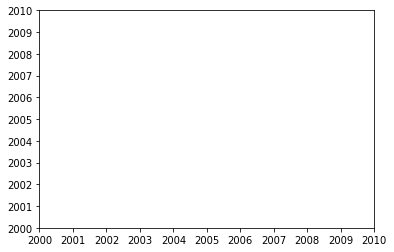

In [42]:
#Cumulative sums
school = 'Midtown Academy'
data_df.sort_values(['Locations affected', 'Date'], ascending=[True, True], inplace=True)
data_df['Cumulative Sum Students'] = data_df.groupby(by='Locations affected')['Number of positive students'].cumsum()
print(data_df.loc[data_df['Locations affected'] == school])
fig, ax = plt.subplots()
ax.plot(data_df['Date'].loc[data_df['Locations affected']==school], data_df['Date'].loc[data_df['Cumulative Sum Students']==school])

## Focus on Midtown Academy (K-5, southside) vs. Dunedin (K-5, north county)

To compare two schools, we select the text in the their names and use pandas to filter the rest of the data. For each one, a time series can be made for both students and employees who have tests positive for COVID 19 during this school year. These schools allow us to use geography as a proxy for how many people may become sick with COVID due to opening schools with no mask mandate and the highly contagious delta variant of COVID causing record daily positive cases and hospitalization in the county and across the state. 

          Date Locations affected  Number of positive employees  \
19  2021/08/13    Midtown Academy                           1.0   

    Number of positive students  Total cases  
19                          0.0          1.0  


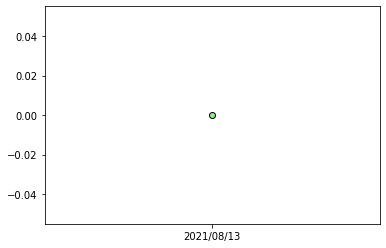

In [50]:
#Use the following two lines to pick data from a single school:
text_in_school1_name = 'Midtown'
school1_df = data_df[data_df['Locations affected'].astype(str).str.contains(text_in_school1_name)].sort_values(by='Date', ascending=True)
print(school1_df)

text_in_school2_name = 'Dunedin Elementary'
school2_df = data_df[data_df['Locations affected'].astype(str).str.contains(text_in_school2_name)].sort_values(by='Date', ascending=True)

_, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(
    (school2_df['Date']),
    school2_df['Number of positive students'],
    color='yellow', 
    mec='k',
    marker='o',
    linestyle=" "
)
ax.plot(
    (school1_df['Date']),
    school1_df['Number of positive students'],
    color='lightgreen', 
    mec='k',
    marker='o',
    linestyle=" "
)


#fmt_weekly = mdates.DayLocator(interval=2)
#ax.xaxis.set_major_locator(fmt_weekly)
#ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

In [55]:
#Condensed code with exception handling from Dahomey Kadera: 
#Runs a bit slower than the PCS_COVID_ScraPy package, perhaps more dependable though.

from selenium import webdriver
import time
from  bs4 import BeautifulSoup
import pandas as pd

driver = webdriver.Chrome(driver_path)
driver.get(URL)
driver.maximize_window()

time.sleep(1)

date_search = driver.find_element_by_id("sw-minibasefilter65979-field-0")
date_search.clear()
date_search.send_keys("2021")

time.sleep(1)

submit_enter = driver.find_element_by_id("minibaseSubmit65979")
submit_enter.click()

def initiate_soup():
  time.sleep(2)
  el = driver.find_element_by_class_name("sw-flex-table")
  return BeautifulSoup(el.get_attribute("outerHTML"), "html.parser")

column_names = []
soup = initiate_soup()
header = soup.find('tr')
for th in header.find_all('th'):
  column_names.append(th.get_text())

df = pd.DataFrame(columns = column_names)
  
def get_rows():
  global df
  soup = initiate_soup()
  rows = soup.find_all('tr')
  for row in rows[1: ]:
    this_row = []
    for td in row.find_all('td'):
      this_row.append(td.get_text())
    values_to_add = {}
    for i in range(len(column_names)): 
      values_to_add[column_names[i]] = this_row[i]
    row_to_add = pd.Series(values_to_add, name=len(df))
    df = df.append(row_to_add)	

get_rows()	
	
for i in range(2,100): 
  x_path_go = "//li/a[@aria-label='Go to Page %s']"%(str(i))
  x_path_skip = "//li/a[@aria-label='Skip to Page %s']"%(str(i))  
  #print(x_path_go)
  #print(x_path_skip)
  try: 
    pge = driver.find_element_by_xpath(x_path_go)
    if pge: 
      pge.click()
      get_rows()
  except: 
    pass
  
  try: 
    pge_s = driver.find_element_by_xpath(x_path_skip)
    if pge_s: 
      pge_s.click()
      get_rows()
  except: 
    pass  
	  
print(column_names)
df.to_csv("cov_dat_Dahomey_20210817.csv")


['Date', 'Locations affected', 'Number of positive employees', 'Number of positive students']


In [63]:
print(df.shape)



(409, 4)
           Date                     Locations affected  \
0    2021/08/16                Administration Building   
1    2021/08/16                   Azalea Middle School   
2    2021/08/16              Blanton Elementary School   
3    2021/08/16                Calvin Hunsinger School   
4    2021/08/16                  Carwise Middle School   
..          ...                                    ...   
404  2021/07/12  Pinellas Technical College Clearwater   
405  2021/07/12                 Seminole Middle School   
406  2021/07/12               Sexton Elementary School   
407  2021/07/12           Sutherland Elementary School   
408  2021/07/12          Walter Pownall Service Center   

    Number of positive employees Number of positive students  Total cases  
0                              2                           0          NaN  
1                              0                           1          NaN  
2                              2                           0      